In [ ]:
import os
import sys
import pandas as pd
import importlib
import scienceplots

# Add the modules directory to Python path
modules_path = '/Users/fomo/Documents/Kaizen/code/neuroelectrophysiology/modules'
if modules_path not in sys.path:
    sys.path.insert(0, modules_path)

import openephysextract

from matplotlib import pyplot as plt

plt.style.use(['science', 'grid'])
plt.rc('font', weight='bold')
plt.rc('figure', titlesize = 33, figsize = (21, 7), dpi = 210,
             titleweight = 'bold')
plt.rc('axes', titlesize = 27, labelsize = 21, titlepad = 21,
             labelweight = 'bold', labelpad = 21, titleweight = 'bold')
plt.rc('legend', fontsize = 21, framealpha = 0.8)
plt.rc('xtick', labelsize = 21)
plt.rc('ytick', labelsize = 21)

source = '/Volumes/STORAGE 1.0/UNIC Research/5xFAD Resting State'
master = '/Users/fomo/Documents/Research/UNIC Research/Neuroelectrophysiology'
experiment = '5xFAD Resting State'
destination = os.path.join(master, experiment)
local_path = '/Users/fomo/Local Data/5xFAD Resting State'

ModuleNotFoundError: No module named 'openephysextract'

# 5xFAD Resting State EEG Analysis
### Define mapping between animal IDs and phenotypes

In [15]:
importlib.reload(openephysextract.utilities)
from openephysextract.utilities import spreadsheet, loadify, savify

notes = spreadsheet(
    location = os.path.join(master, 'notes'),
    name = 'MICE_LIST_EEG.xlsx',
    id = 'Session',
    relevant = sorted(os.listdir(source)),
    sheet = 'MEP'
)

animals = pd.read_excel(
    os.path.join(master, 'notes', 'MICE_LIST_EEG.xlsx'), sheet_name='animals'
)

phenotypes = {}

for _, row in animals.iterrows():
    phenotypes[row['Animal ID']] = row['Phenotype']

notes['group'] = notes['AnimalID'].map(phenotypes)

notes.head(5)

,Session,AnimalID,SessionClass,SessionType,currentLevel,isoflo,messages,subrecidx,subrec1,subrec2,group
0,2023-08-25_14-20-15,33B1,NaN,NaN,NaN,NaN,33B1 baseline 1.5%isoflo 33B1 baseline 1.5%iso...,1,NaN,NaN,WT
1,2023-08-25_15-32-14,33C7,NaN,NaN,NaN,NaN,33C7 baseline baseline done,1,NaN,NaN,WT
2,2023-08-25_16-48-03,33C5,NaN,NaN,NaN,NaN,33C5 baseline,1,NaN,NaN,WT
3,2023-08-25_17-48-53,33E1,NaN,NaN,NaN,NaN,33E1 baseline 33E1 baseline done,1,NaN,NaN,WT
4,2023-08-25_18-47-30,33E3,NaN,NaN,NaN,NaN,33E3 baseline 33E3 baseline done,1,NaN,NaN,WT


## I Preprocessing

In [16]:
import openephysextract.session
importlib.reload(openephysextract.session)
import openephysextract.extractor
importlib.reload(openephysextract.extractor)
from openephysextract.extractor import Extractor

extractor = Extractor(
    source = source,
    experiment = '5xFAD Resting State',
    sampling_rate = 30000,
    output = local_path,
    notes = notes,
    channels = [3, 4, 5, 6, 7, 8]
)

out = extractor.extractify(export = False)

Extracting Sessions: 100%|██████████| 17/17 [00:36<00:00,  2.16s/file]


### I.II Preprocessing

1, 2 primary motor cortex <br>
3, 4 S1 L + R <br>
5, 6 V1/V2 L + R <br>

In [7]:
out = loadify('5xFAD Resting State RAW.pkl', local_path)

In [17]:
print(out[1].raw)

[[ -5.85         1.9499999  -14.624999   ...   9.75        23.205
   23.4       ]
 [-27.689999   -15.405      -27.689999   ...  31.98        44.265
   45.239998  ]
 [-23.205      -11.7        -25.154999   ...  20.474998    29.249998
   30.615     ]
 [-35.1        -20.474998   -34.905      ...  36.465       44.655
   54.015     ]
 [-29.64       -16.574999   -24.96       ...  25.349998    23.205
   37.829998  ]
 [  0.67619205   0.67619205   0.67619205 ...   0.6707316    0.66957223
    0.66957223]]


In [32]:
importlib.reload(openephysextract.utilities)
importlib.reload(openephysextract.preprocess)
import openephysextract.preprocess
importlib.reload(openephysextract.preprocess)
from openephysextract.preprocess import (
    Preprocessor,
    RemoveBadStep,
    FilterStep,
    DownsampleStep,
    EpochStep,
    StandardizeStep
)

steps = [
    RemoveBadStep(
        std=True,            # use z-score of hybrid distance
        alpha=0.5, beta=0.5, 
        cutoff_pct=90
    ),
    FilterStep(
        lowcut=0.1,          # remove drift
        highcut=80,          
        order=4
    ),
    DownsampleStep(
        target_fs=100,       # downsample to 100Hz
        downsample_raw=True
    ),
    EpochStep(
        frame=100,           # 1s @100Hz
        stride=10,           # 90% overlap → 0.1s steps
    ),
    StandardizeStep(
        method='zscore',     # z-score standardization
        per_epoch=True       # standardize each epoch independently
    )
]

preprocessor = Preprocessor(
    steps=steps,
    device='mps',
    log=False,
    verbose=False
)

preprocessed = preprocessor.preprocess(
    out,
    use_gpu=True
)

Preprocessing: 100%|██████████| 17/17 [02:04<00:00,  7.31s/session]



In [19]:
print(preprocessed[0].data, type(preprocessed[0].raw), preprocessed[0].data.shape)

[[[ 0.7153165   1.1624273   0.8931702  ...  0.62720627  0.31948826
    0.13316354]
  [ 0.44067037  0.5886368   0.5351584  ...  0.97138184  0.5697785
    0.63346153]
  [ 0.584585    1.0892212   0.92982996 ...  0.75753707  0.5456848
    0.37600994]
  [ 0.22133379  0.51643693  0.5645684  ...  1.0550085   0.8405861
    0.91205543]
  [ 0.23798847  1.048856    0.8622177  ...  0.5307298   0.2875348
    0.08072986]]

 [[-0.33684456 -0.75192904 -0.82918334 ... -0.9789471  -0.9127832
   -0.5175348 ]
  [-0.55098855 -0.77610284 -0.8897108  ... -1.0410581  -0.8439721
   -0.27968842]
  [-0.4722954  -0.6101733  -0.5641571  ... -0.85320896 -0.78764987
   -0.36911404]
  [-0.4376845  -0.41371626 -0.5921477  ... -1.2265439  -0.8786923
   -0.28874853]
  [-0.6526087  -0.543724   -0.25116667 ... -0.94785863 -0.80374795
   -0.1864471 ]]

 [[-1.9761804  -1.9492918  -1.8609996  ... -0.4862557  -0.36790934
   -0.30883095]
  [-2.3339055  -2.2003868  -1.8746185  ... -0.6009994  -0.6607863
   -0.5065128 ]
  [-2.28

In [33]:
for session in preprocessed:
    outpath = os.path.join("5xFAD-resting-state-preprocessed", f'{session.session}.h5')
    session.to_hdf5(outpath)

Saving to 5xFAD-resting-state-preprocessed/2023-08-25_14-20-15.h5...
  - Raw data shape: (6, 35323)
  - Preprocessed data shape: (5, 35323)
  - Final data shape: (3523, 5, 100)
Saving to 5xFAD-resting-state-preprocessed/2023-08-25_15-32-14.h5...
  - Raw data shape: (6, 32014)
  - Preprocessed data shape: (5, 32014)
  - Final data shape: (3192, 5, 100)
Saving to 5xFAD-resting-state-preprocessed/2023-08-25_15-32-14.h5...
  - Raw data shape: (6, 32014)
  - Preprocessed data shape: (5, 32014)
  - Final data shape: (3192, 5, 100)
Saving to 5xFAD-resting-state-preprocessed/2023-08-25_16-48-03.h5...
  - Raw data shape: (6, 31468)
  - Preprocessed data shape: (5, 31468)
  - Final data shape: (3137, 5, 100)
Saving to 5xFAD-resting-state-preprocessed/2023-08-25_16-48-03.h5...
  - Raw data shape: (6, 31468)
  - Preprocessed data shape: (5, 31468)
  - Final data shape: (3137, 5, 100)
Saving to 5xFAD-resting-state-preprocessed/2023-08-25_17-48-53.h5...
  - Raw data shape: (6, 30674)
  - Preprocesse

In [37]:
# Test the fix by reloading the preprocess module
import importlib
importlib.reload(openephysextract.preprocess)

from openephysextract.session import Session

# Load a session from the saved HDF5 files
session_files = [f for f in os.listdir("5xFAD-resting-state-preprocessed") if f.endswith('.h5')]
print(f"Available session files: {session_files}")

# Load the first session as an example
if session_files:
    session_path = os.path.join("5xFAD-resting-state-preprocessed", session_files[5])
    loaded_session = Session.from_hdf5(session_path)
    print(f"Loaded session: {loaded_session.session}")
    print(f"Data shape: {loaded_session.data.shape}")
    print(f"Available attributes: {[attr for attr in dir(loaded_session) if not attr.startswith('_')]}")
    
    # Check if metadata is preserved
    print(f"Good channels: {loaded_session.good_channels}")
    print(f"Stats: {loaded_session.stats}")
    print(f"History length: {len(loaded_session.history) if loaded_session.history else 0}")
    
    # If good_channels is still empty, we need to reprocess with the fixed code
    if not loaded_session.good_channels:
        print("\n⚠️  good_channels is still empty - need to reprocess with fixed RemoveBadStep")
        print("Run the preprocessing cell again to regenerate the HDF5 files with proper metadata")
else:
    print("No HDF5 files found in the data directory")

Available session files: ['2023-09-06_17-32-01.h5', '2023-08-25_23-24-25.h5', '2023-09-06_15-06-20.h5', '2023-08-26_00-12-57.h5', '2023-08-25_15-32-14.h5', '2023-08-26_00-58-14.h5', '2023-08-25_20-33-11.h5', '2023-08-25_17-48-53.h5', '2023-08-25_16-48-03.h5', '2023-09-06_19-26-36.h5', '2023-08-26_01-43-12.h5', '2023-08-25_14-20-15.h5', '2023-08-25_21-35-02.h5', '2023-08-25_22-02-17.h5', '2023-08-25_18-47-30.h5', '2023-08-25_19-39-21.h5', '2023-08-26_02-33-36.h5']
Loaded session: 2023-08-26_00-58-14
Data shape: (3193, 5, 100)
Available attributes: ['add_notes', 'annotate', 'bad_ics', 'ch_names', 'data', 'duration', 'events', 'experiment', 'from_dict', 'from_hdf5', 'good_channels', 'group', 'history', 'ica_model', 'ica_sources', 'load', 'location', 'log_step', 'montage', 'notes', 'original_channels', 'preprocessed', 'raw', 'sampling_rate', 'save', 'schema_version', 'session', 'shape', 'states', 'stats', 'times', 'to_dict', 'to_hdf5']
Good channels: [0, 1, 2, 3, 4]
Stats: {'remove_bad': {

## II Analysis

In [39]:
# Test the index conversion by examining the HDF5 file directly
import h5py
import json

# Check what's actually in the HDF5 file
session_path = "5xFAD-resting-state-preprocessed/2023-08-25_15-32-14.h5"

with h5py.File(session_path, 'r') as f:
    print("HDF5 file attributes:")
    for key in f.attrs.keys():
        attr_val = f.attrs[key]
        print(f"  {key}: {attr_val}")
        
        # If it's a JSON string, parse it
        if isinstance(attr_val, str) and key in ['good_channels', 'bad_ics', 'events']:
            try:
                parsed = json.loads(attr_val)
                print(f"    → parsed: {parsed}")
            except:
                pass
        
    print(f"\nData shapes:")
    for key in f.keys():
        print(f"  {key}: {f[key].shape}")

HDF5 file attributes:
  ch_names: []
  experiment: 5xFAD Resting State
  good_channels: [0, 1, 2, 3, 4]
    → parsed: [0, 1, 2, 3, 4]
  group: WT
  history: [{"step": "RemoveBadStep", "params": {"std": true, "alpha": 0.5, "beta": 0.5, "cutoff": 90, "verbose": false}, "time": "2025-08-02T14:56:56.502877"}, {"step": "FilterStep", "params": {"lowcut": 0.1, "highcut": 80, "order": 4, "notch_freqs": [], "detrend": false, "verbose": false}, "time": "2025-08-02T14:56:57.979584"}, {"step": "DownsampleStep", "params": {"target_fs": 100, "downsample_raw": true, "verbose": false}, "time": "2025-08-02T14:57:00.182022"}, {"step": "EpochStep", "params": {"frame": 100, "stride": 10, "baseline_ms": 0, "verbose": false}, "time": "2025-08-02T14:57:00.209392"}, {"step": "StandardizeStep", "params": {"method": "zscore", "per_epoch": true, "verbose": false}, "time": "2025-08-02T14:57:00.233851"}]
  location: /Volumes/STORAGE 1.0/UNIC Research/5xFAD Resting State/2023-08-25_15-32-14
  notes: {"schema_versio

### II.I PSD Analysis

(5, 30473) [0, 1, 2, 3, 4]


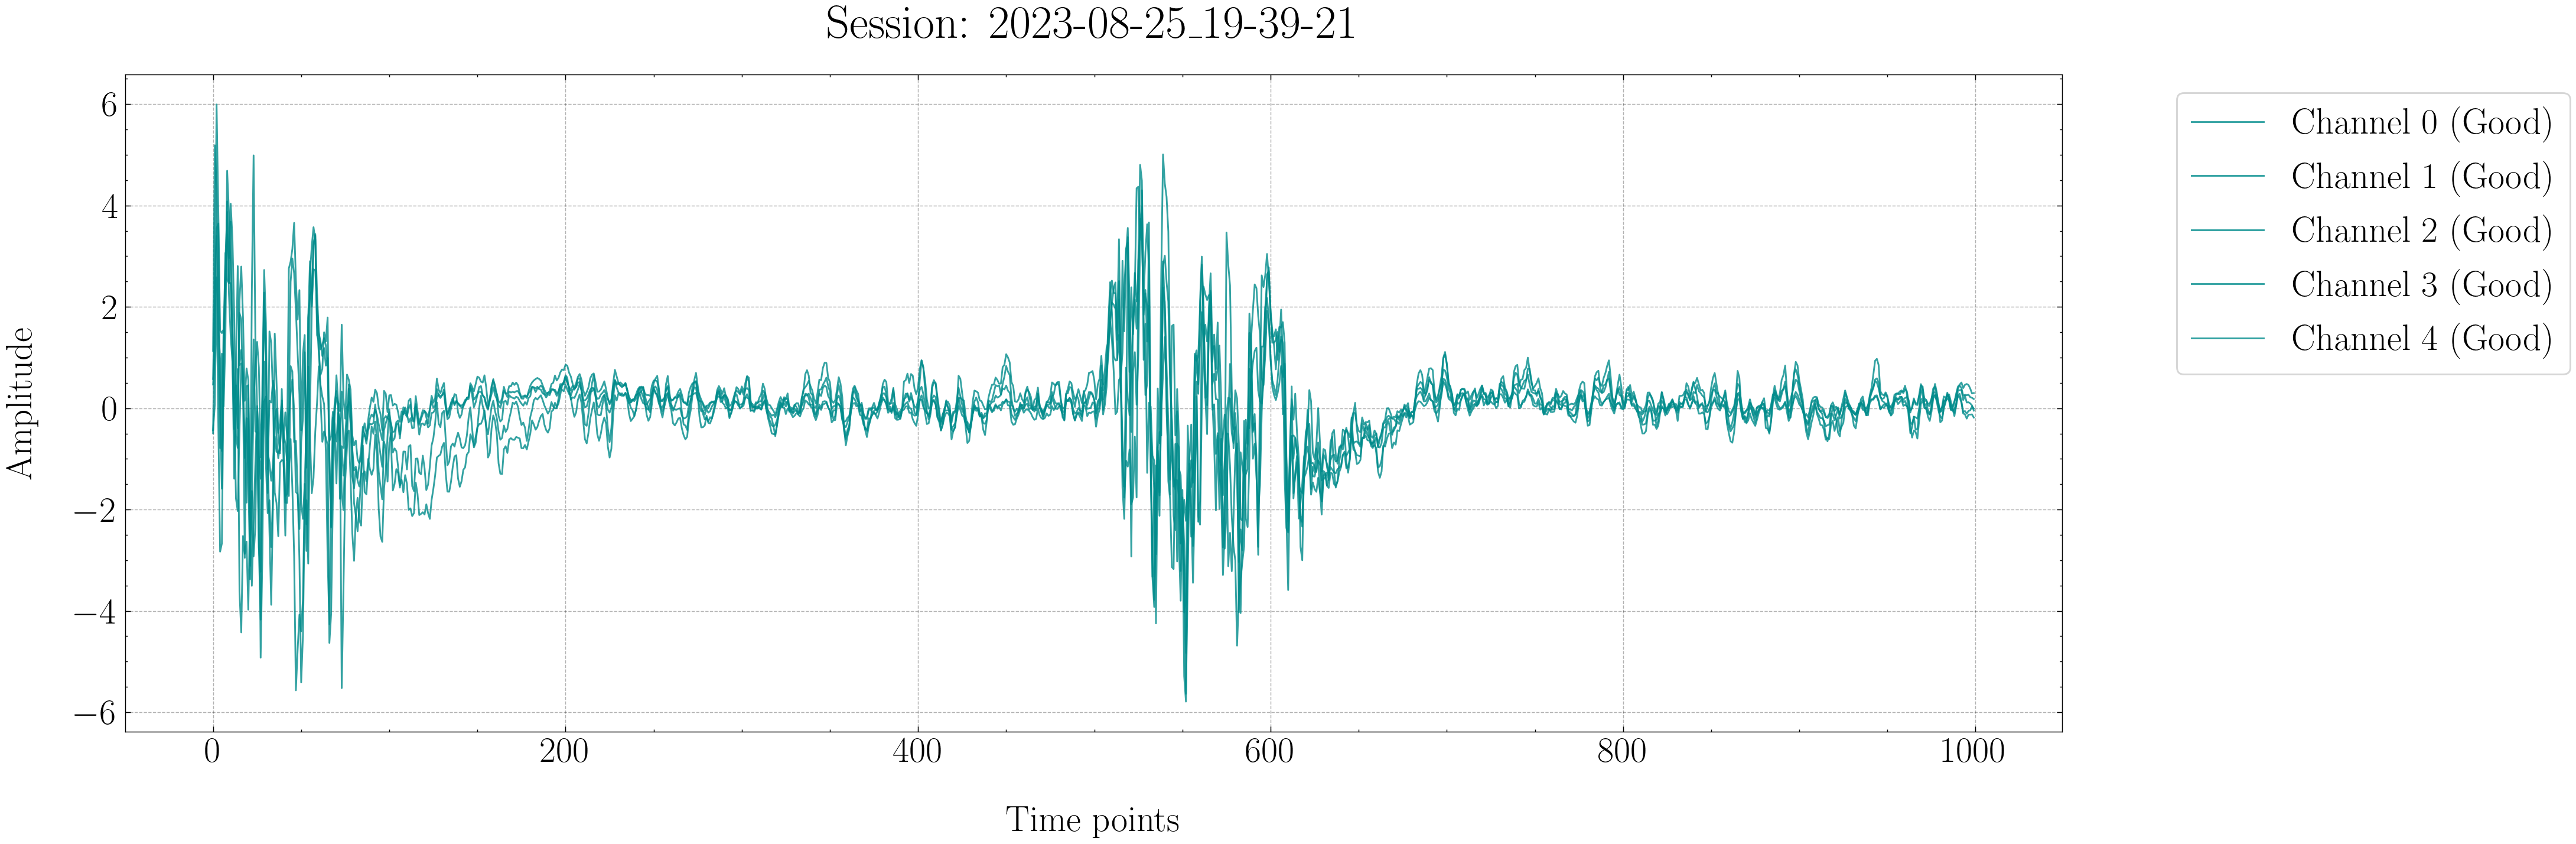

In [36]:
def plot_session_channels(session):
    plt.figure(figsize=(21, 7), dpi = 210)
    channels = range(session.preprocessed.shape[0])
    good_channels = session.good_channels if hasattr(session, 'good_channels') else channels
    print(session.preprocessed.shape, good_channels)
    for i in channels:
        color = 'darkcyan' if i in good_channels else 'red'
        plt.plot(session.preprocessed[i, :1000], color=color, alpha=0.8,
                 label=f'Channel {i} {"(Good)" if i in good_channels else "(Bad)"}')

    plt.title(f'Session: {session.session}')
    plt.xlabel('Time points')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_session_channels(preprocessed[5])

In [80]:
import openephysextract.analysis
importlib.reload(openephysextract.analysis)
from openephysextract.analysis import bandpower

features = [bandpower(session) for session in preprocessed]


In [ ]:
features[0]

### II.II Logistic Scaling (Garwood et. al)

In [ ]:
import openephysextract.analysis
importlib.reload(openephysextract.analysis)
from openephysextract.analysis import logistic_scaler as scaler

scaled = [scaler(trial) for trial in features]

savify(scaled, output_2, "logistic-scaled")

In [ ]:
scaled = loadify(output_2, "logistic-scaled")
scaled[0].data.shape

In [ ]:
import openephysextract.plot
importlib.reload(openephysextract.plot)
from openephysextract.plot import plotifyEEGbands

plotifyEEGbands(scaled[0])

In [ ]:
importlib.reload(openephysextract.utilities)
from openephysextract.utilities import spreadsheet

notes = spreadsheet(
    location = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials/notes',
    name = 'MICE_LIST_EEG.xlsx',
    id = 'Session',
    relevant = [trial.trial for trial in scaled],
    sheet = 'MEP'
)

notes['group'] = notes['AnimalID'].map(phenotypes)

for trial in scaled:
    info = notes[notes['Session'] == trial.trial].iloc[0].to_dict()
    trial.add_notes(info)
    
savify(scaled, output_2, 'logistic-scaled-with-notes')

## III beta-HMM Construction

### III.I 

In [ ]:
import numpy as np
from scipy.special import logsumexp
from scipy.stats import beta
from tqdm import tqdm

class BetaHMM:
    """
    Hidden Markov Model with beta emission distributions.
    Optimized for vectorized forward/backward and EM convergence.
    """
    def __init__(self, n_states, n_features, seed=None):
        self.K = n_states
        self.D = n_features
        self.rng = np.random.default_rng(seed)

        # model parameters
        self.pi = self.rng.dirichlet(np.ones(self.K))               # initial state distribution
        self.A  = self.rng.dirichlet(np.ones(self.K), size=self.K)  # transition matrix
        # beta parameters to ensure unimodal; will be re-estimated
        self.alpha = self.rng.uniform(1.5, 3.0, size=(self.K, self.D))
        self.beta  = self.rng.uniform(1.5, 3.0, size=(self.K, self.D))

    def _compute_ll(self, Y):
        """
        Compute log-likelihood matrix of shape (N, K).
        """
        Y = np.clip(Y, 1e-6, 1 - 1e-6)
        return np.stack([
            np.sum(beta.logpdf(Y, self.alpha[k], self.beta[k]), axis=1)
            for k in range(self.K)
        ], axis=1)

    def _forward(self, LL, log_pi, log_A):
        N, K = LL.shape
        log_alpha = np.zeros((N, K))
        log_alpha[0] = log_pi + LL[0]
        for n in range(1, N):
            log_alpha[n] = LL[n] + logsumexp(log_alpha[n-1][:, None] + log_A, axis=0)
        return log_alpha

    def _backward(self, LL, log_A):
        N, K = LL.shape
        log_beta = np.zeros((N, K))
        for n in range(N-2, -1, -1):
            log_beta[n] = logsumexp(
                log_A + LL[n+1][None, :] + log_beta[n+1][None, :],
                axis=1
            )
        return log_beta

    def _compute_gamma_xi(self, log_alpha, log_beta, LL, log_A):
        N, K = log_alpha.shape
        # gamma: posterior state marginals
        log_gamma = log_alpha + log_beta
        log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
        gamma = np.exp(log_gamma)

        # xi: posterior transition counts
        xi = np.zeros((N-1, K, K))
        for n in range(N-1):
            log_xi_raw = (
                    log_alpha[n][:, None] + log_A +
                    LL[n+1][None, :] + log_beta[n+1][None, :]
            )
            log_xi = log_xi_raw - logsumexp(log_xi_raw)
            xi[n] = np.exp(log_xi)
        return gamma, xi

    def em_step(self, Y):
        LL      = self._compute_ll(Y)
        log_pi  = np.log(np.clip(self.pi, 1e-12, 1.0))
        log_A   = np.log(np.clip(self.A,  1e-12, 1.0))
        log_a   = self._forward(LL, log_pi, log_A)
        log_b   = self._backward(LL, log_A)
        gamma, xi = self._compute_gamma_xi(log_a, log_b, LL, log_A)

        # M-step: update pi and A
        self.pi = gamma[0]
        A_counts = xi.sum(axis=0)
        self.A = A_counts / A_counts.sum(axis=1, keepdims=True)

        # update beta parameters via weighted moments
        for k in range(self.K):
            w = gamma[:, k]
            w_sum = w.sum()
            if w_sum < 1e-8:
                continue
            mean = (w[:, None] * Y).sum(axis=0) / w_sum
            var  = (w[:, None] * (Y - mean)**2).sum(axis=0) / w_sum
            var  = np.clip(var, 1e-4, None)
            v    = np.maximum(mean * (1 - mean) / var - 1, 1e-2)
            self.alpha[k] = np.clip(mean * v,     1e-2, 1e2)
            self.beta[k]  = np.clip((1 - mean)*v, 1e-2, 1e2)

        return logsumexp(log_a[-1])

    def fit(self, Y, max_iters=100, tol=1e-4):
        """
        Run EM until convergence or max iterations on a single sequence.
        """
        prev_ll = -np.inf
        for _ in range(max_iters):
            ll = self.em_step(Y)
            if ll - prev_ll < tol:
                break
            prev_ll = ll
        return self

    def fit_multi(self, Y_list, max_iters=50, tol=1e-4):
        """
        Fit a single Beta-HMM across multiple independent sequences.
        """
        prev_ll = -np.inf

        for _ in tqdm(range(max_iters)):
            total_ll = 0.0
            # Reset accumulators each iteration
            pi_acc      = np.zeros(self.K)
            A_acc       = np.zeros((self.K, self.K))
            sum_weight  = np.zeros(self.K)
            sum_Y       = np.zeros((self.K, self.D))
            sum_Y2      = np.zeros((self.K, self.D))

            # E-step: loop over trials
            for Y in Y_list:
                LL      = self._compute_ll(Y)
                log_pi  = np.log(np.clip(self.pi, 1e-12, 1.0))
                log_A   = np.log(np.clip(self.A,  1e-12, 1.0))
                log_a   = self._forward(LL, log_pi, log_A)
                log_b   = self._backward(LL, log_A)
                gamma, xi = self._compute_gamma_xi(log_a, log_b, LL, log_A)

                total_ll += logsumexp(log_a[-1])
                pi_acc   += gamma[0]
                A_acc    += xi.sum(axis=0)

                for k in range(self.K):
                    w = gamma[:, k]
                    sum_weight[k] += w.sum()
                    sum_Y[k]      += (w[:, None] * Y).sum(axis=0)
                    sum_Y2[k]     += (w[:, None] * (Y**2)).sum(axis=0)

            # M-step: update shared parameters
            self.pi = pi_acc / pi_acc.sum()
            self.A  = A_acc  / A_acc.sum(axis=1, keepdims=True)

            for k in range(self.K):
                mean = sum_Y[k] / sum_weight[k]
                var  = (sum_Y2[k] / sum_weight[k]) - mean**2
                var  = np.clip(var, 1e-4, None)
                prec = np.maximum(mean * (1 - mean) / var - 1, 1e-2)
                self.alpha[k] = np.clip(mean * prec,     1e-2, 1e2)
                self.beta[k]  = np.clip((1 - mean)*prec, 1e-2, 1e2)

            if total_ll - prev_ll < tol:
                break
            prev_ll = total_ll

        return self

    def viterbi(self, Y):
        """
        Decode one sequence into its most likely state path.
        """
        LL    = self._compute_ll(Y)
        N, K  = LL.shape
        delta = np.zeros((N, K))
        psi   = np.zeros((N, K), dtype=int)

        delta[0] = np.log(np.clip(self.pi, 1e-12, 1.0)) + LL[0]
        log_A    = np.log(np.clip(self.A, 1e-12, 1.0))

        for n in range(1, N):
            scores     = delta[n-1][:, None] + log_A
            psi[n]     = np.argmax(scores, axis=0)
            delta[n]   = scores[psi[n], range(K)] + LL[n]

        states = np.zeros(N, dtype=int)
        states[-1] = np.argmax(delta[-1])
        for n in range(N-2, -1, -1):
            states[n] = psi[n+1, states[n+1]]

        return states

    def viterbi_multi(self, Y_list):
        """
        Decode each sequence in Y_list independently.
        """
        return [self.viterbi(Y) for Y in Y_list]


### III.II Model Order Selection

In [ ]:
trials = loadify(output_2, 'logistic-scaled-with-notes')

In [ ]:
Ys = [t.data.reshape(t.data.shape[0], -1) for t in trials]

In [ ]:
bic_scores = []

models = {}

Ks = range(2, 16)
for K in Ks:
    model = BetaHMM(n_states=K, n_features=Ys[0].shape[1], seed=0)
    model.fit_multi(Ys)
    ll = sum(model._compute_ll(Y).max(axis=1).sum() for Y in Ys)  # or store EM log-likelihood
    N_total = sum(Y.shape[0] for Y in Ys)

    p = (K - 1) + K*(K - 1) + 2 * K * model.D
    bic = -2 * ll + p * np.log(N_total)
    bic_scores.append(bic)
    
    models[K] = model
    
best_K = Ks[np.argmin(bic_scores)]
colors = ['red' if i == best_K else 'gray' for i in range(len(Ks))]

plt.figure(figsize=(21, 7), dpi = 210)
plt.bar(Ks, bic_scores, color=colors)
plt.xlabel('Number of States (K)')
plt.ylabel('BIC')
plt.title('Model Selection via BIC')
plt.xticks(Ks)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

savify(models, output_2, 'beta_hmm_models')

In [ ]:
best_K, bic_scores, models

In [ ]:
models = loadify(output_2, 'beta_hmm_models')

In [ ]:
from tqdm import tqdm

states = {}
for K, model in tqdm(models.items()):
    K = int(K)
    states[K] = model.viterbi_multi(Ys)

### III.III Visualising Dynamics

#### III.III.I State Trajectory

In [ ]:
def find_most_consistent_state(seqs):
    """
    Given a list of integer state sequences (each of length T_i),
    find the state k whose first‐entry times (across trials that visit it)
    have the smallest variance.
    """
    first_times = {}
    for seq in seqs:
        for k in np.unique(seq):
            idx = np.where(seq == k)[0]
            if idx.size:
                first_times.setdefault(k, []).append(idx[0])
    # only consider states seen in at least half the trials
    n_trials = len(seqs)
    cons = {}
    for k, times in first_times.items():
        if len(times) >= n_trials/2:
            cons[k] = np.var(times)
    if not cons:
        return None
    return min(cons, key=cons.get)

def align_on_state(seqs, state, window):
    """
    Align each seq at its first entry into `state`, take exactly `window` steps after.
    """
    aligned = []
    for seq in seqs:
        idx = np.where(seq == state)[0]
        if idx.size:
            start = idx[0]
            if start + window <= len(seq):
                aligned.append(seq[start:start+window])
    return np.stack(aligned) if aligned else np.empty((0,window),dtype=int)

In [ ]:
Ks = [2, 3, 4, 8]
trial = 5
sequence = states[K][trial]
n_epochs = 500

In [ ]:
from scipy.stats import mode

colors = sns.color_palette('Set2', len(Ks))

phenotypes   = sorted({ tr.notes['group'] for tr in trials })
colors       = sns.color_palette('Set2', len(phenotypes))

fig, axs = plt.subplots(len(Ks), 1, figsize=(21, 3*len(Ks)), sharex=True, dpi = 210)

for ax, K in zip(axs, Ks):
    for ph, color in zip(phenotypes, colors):
        # pick out only those trials of this phenotype
        idxs      = [i for i,tr in enumerate(trials) if tr.notes['group']==ph]
        ph_seqs   = [states[K][i] for i in idxs]

        # find the best “anchor” 
        # state & align
        best_st   = find_most_consistent_state(ph_seqs)
        if best_st is None:
            continue

        aligned   = align_on_state(ph_seqs, best_st, n_epochs)
        if aligned.size == 0:
            continue

        # compute the across‐trial mode path
        mode_path = mode(aligned, axis=0).mode.flatten()
        ax.plot(mode_path,
                lw=3.0,
                label=ph,
                color=color)

    ax.set_ylabel(f'K={K}\nstate', fontsize=12)
    ax.set_yticks(range(K))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(title='Phenotype')

axs[-1].set_xlabel('Epochs after alignment', fontsize=14)
plt.suptitle('Mode Viterbi Paths by Phenotype (aligned on each group’s most‐consistent state)',
             y=1.02,
             fontsize=16)
plt.tight_layout()
plt.show()


#### III.III.II State Occupancy + Dwell Times

In [ ]:
import itertools

rows = []

groups = sorted({trial.notes['group'] for trial in trials})

Ks_sorted = sorted(states.keys())

for K, trial_seqs in states.items():
    for group in groups:
        occ_accum   = {k: [] for k in range(K)}
        dwell_accum = {k: [] for k in range(K)}

        for i, seq in enumerate(trial_seqs):
            if trials[i].notes['group'] != group:
                continue

            # Occupancy: fraction of time in each state
            for k in range(K):
                occ_accum[k].append(np.mean(seq == k))

            # Dwell time: mean length of each visit to each state
            for k_run, g in itertools.groupby(seq):
                if k_run in dwell_accum:
                    dwell_accum[k_run].append(len(list(g)))

        # Store mean across trials
        for k in range(K):
            rows.append({
                'K': K,
                'group': group,
                'state': k,
                'occupancy': np.mean(occ_accum[k]) if occ_accum[k] else 0,
                'dwell_time': np.mean(dwell_accum[k]) if dwell_accum[k] else 0
            })

# Final tidy DataFrame
metrics = pd.DataFrame(rows)
metrics.head()

groups_sorted = sorted(metrics['group'].unique())
states_all = sorted(metrics['state'].unique())
state_colors = sns.color_palette('tab20', len(states_all))

In [ ]:
def plot_metric(metric_name, ylabel, title):
    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.35
    x_pos = np.arange(len(Ks_sorted))

    handles = []

    for gi, group in enumerate(groups_sorted):
        offset = (gi - 0.5) * bar_width  # side-by-side bars per K
        hatch = '///' if group == '5XFAD' else ''  # differentiate group visually
        alpha = 0.9 if group == 'WT' else 0.6       # optional: use transparency too

        for ki, K in enumerate(Ks_sorted):
            df_sub = metrics[(metrics['K'] == K) & (metrics['group'] == group)]
            df_sub = df_sub.sort_values('state')

            bottom = 0
            for _, row in df_sub.iterrows():
                state_idx = row['state']
                height = row[metric_name]
                color = state_colors[state_idx]

                bar = ax.bar(
                    x=x_pos[ki] + offset,
                    height=height,
                    bottom=bottom,
                    width=bar_width,
                    color=color,
                    hatch=hatch,
                    alpha=alpha,
                    edgecolor='black' if state_idx == 0 else None,
                    label=f"{group} — State {state_idx}"
                )
                bottom += height

    ax.set_xticks(x_pos)
    ax.set_xticklabels(Ks_sorted)
    ax.set_xlabel('Number of States (K)')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.3)

    # custom legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    ax.legend(
        by_label.values(),
        by_label.keys(),
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        title='Group — State',
        borderaxespad=0.
    )

    # Give extra room on the right for the legend
    fig.subplots_adjust(right=0.8)
    plt.show()

In [ ]:
plot_metric(
    metric_name='occupancy',
    ylabel='Average Occupancy',
    title='Average State Occupancy by Group (stacked by state)'
)

In [ ]:
plot_metric(
    metric_name='dwell_time',
    ylabel='Mean Dwell Time (epochs)',
    title='Average State Dwell Time by Group (stacked by state)'
)

#### III.III.III Transition matrix heatmap

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# --- Select specific Ks ---
Ks_selected = [2, 3, 4, 8]  # replace with your desired Ks
phenotypes = sorted({trial.notes['group'] for trial in trials})
n_K = len(Ks_selected)
n_G = len(phenotypes)

# Helper: Estimate transition matrix from list of sequences
def estimate_transition_matrix(seqs, K):
    A = np.zeros((K, K))
    for seq in seqs:
        for i, j in zip(seq[:-1], seq[1:]):
            A[i, j] += 1
    row_sums = A.sum(axis=1, keepdims=True)
    with np.errstate(invalid='ignore'):
        A = np.divide(A, row_sums, where=row_sums != 0)
    return A

# Create subplot grid: rows = phenotypes, cols = selected Ks
fig, axes = plt.subplots(n_G, n_K, figsize=(4 * n_K, 4 * n_G))

for row, group in enumerate(phenotypes):
    for col, K in enumerate(Ks_selected):
        ax = axes[row, col] if n_G > 1 else axes[col]

        # Get sequences of this group at this K
        seqs = [seq for seq, trial in zip(states[K], trials) if trial.notes['group'] == group]

        if len(seqs) == 0:
            ax.axis('off')
            continue

        A = estimate_transition_matrix(seqs, K)
        sns.heatmap(A, annot=True, fmt='.2f', cbar=False, ax=ax,
                    vmin=0, vmax=1, square=True, cmap='viridis')

        ax.set_title(f'K={K}', fontsize=10)
        ax.set_xlabel('to')
        if col == 0:
            ax.set_ylabel(f'{group}\nfrom', fontsize=10)
        else:
            ax.set_ylabel("")

# Layout tweaks
plt.suptitle('Transition Matrices by Phenotype (Selected K)', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

## Other

In [ ]:
names = [trial.trial for trial in scaled]
